In [2]:
using DataStructures
using Formatting: printfmt
using LightGraphs
using Plots
using ScHoLP
using SimpleWeightedGraphs

# Load Data.

Load a dataset in the form of simplices from the ScHoLP package.

In [3]:
dataset_name = "email-Enron"

# Copied from ScHoLP-Tutorial/common.jl
function read_txt_data(dataset::String)
    function read(filename::String)
        ret = Int64[]
        open(filename) do f
            for line in eachline(f)
                push!(ret, parse(Int64, line))
            end
        end
        return ret
    end
    return HONData(read("../data/$(dataset)/$(dataset)-simplices.txt"),
                   read("../data/$(dataset)/$(dataset)-nverts.txt"),
                   read("../data/$(dataset)/$(dataset)-times.txt"),
                   dataset)
end
ex = read_txt_data(dataset_name)

# Gather the edges that exist in the projected graph.
my_edges = Dict()
my_vertices = Set()
vertex_id = Dict()
let idx = 0
    for nvert in ex.nverts
        for i in range(idx+1, stop=idx+nvert)
            for j in range(i+1, stop=idx+nvert)
                v_i, v_j = ex.simplices[i], ex.simplices[j]
                if !haskey(vertex_id, v_i)
                    vertex_id[v_i] = length(vertex_id) + 1
                end
                if !haskey(vertex_id, v_j)
                    vertex_id[v_j] = length(vertex_id) + 1
                end
                u, v = -1, -1
                if vertex_id[v_i] < vertex_id[v_j]
                    u, v = vertex_id[v_i], vertex_id[v_j]
                else
                    u, v = vertex_id[v_j], vertex_id[v_i]
                end
                edge = (u, v)
                if !haskey(my_edges, edge)
                    my_edges[edge] = 0
                end
                my_edges[edge] += 1
                push!(my_vertices, vertex_id[v_i])
                push!(my_vertices, vertex_id[v_j])
            end
        end
        idx += nvert
    end
end

n, m = length(my_vertices), length(my_edges)

(143, 1800)

# Construct the graph.

We will store the graph as an edge list and as an adjacency list. The former allows us to sample the initial edge $(a,b)$ efficiently while the latter allows us to sample edges $(a,c)$ and $(b,c')$ efficiently.

In [4]:
# Construct an edge list representation of the graph.
edge_list = collect(my_edges)

# Construct an adjacency list representation of the graph.
adj_list = SimpleWeightedGraph(n)
for ((u, v), w) in edge_list
    add_edge!(adj_list, u, v, w)
    add_edge!(adj_list, v, u, w)
end

# Analysis of edge weights.

In [5]:
my_weights = [w for (_, w) in edge_list];

## Range of weights.

In [6]:
printfmt("Minimum edge weight: {}, maximum edge weight: {}", minimum(my_weights), maximum(my_weights))

Minimum edge weight: 1, maximum edge weight: 819

## Distribution of weights.

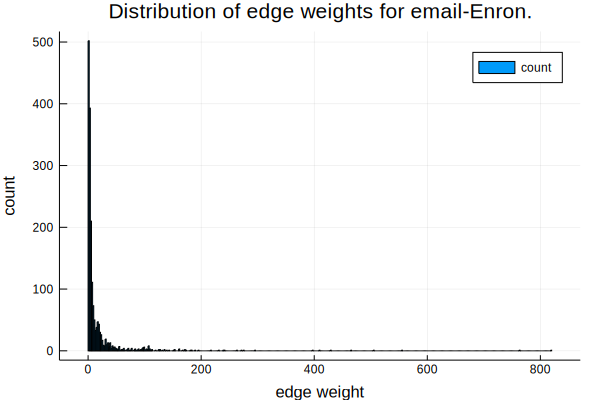

In [8]:
histogram(my_weights, bins=:auto, xlabel="edge weight", ylabel="count", label="count",
          title="Distribution of edge weights for $dataset_name.")

## Distribution of weights around a vertex.

Are the edge weights around a vertex roughly uniform or are there edges which account for a large fraction of the weight?

In [9]:
max_prob, max_v = 0, -1
for v in vertices(adj_list)
    if length(neighbors(adj_list, v)) <= 1
        continue
    end
    my_weights = adj_list.weights[v, neighbors(adj_list, v)]
    if maximum(my_weights ./ sum(my_weights)) > max_prob
        max_prob = maximum(my_weights ./ sum(my_weights))
        max_v = v
    end
end
printfmt("Vertex $max_v has an edge which accounts for {:.2f} probability.", max_prob)

Vertex 113 has an edge which accounts for 0.77 probability.

In [10]:
k = 10
heavy_probs = []
for v in vertices(adj_list)
    if length(neighbors(adj_list, v)) <= 1
        continue
    end
    my_weights = adj_list.weights[v, neighbors(adj_list, v)]
    probs = my_weights ./ sum(my_weights)
    for p in probs
        push!(heavy_probs, (p, v))
    end
end
top_k = nlargest(k, heavy_probs);
printfmt("{:7} {}", "Vertex", "Edge accounting for probability.\n")
for (p, v) in top_k
    printfmt("{:7}, {:.2f}\n", v, p)
end

Vertex  Edge accounting for probability.
113    , 0.77
67     , 0.56
100    , 0.55
126    , 0.52
123    , 0.50
93     , 0.50
93     , 0.50
83     , 0.48
104    , 0.46
127    , 0.43
